### Chapter 3.2.4 codes, model selection with 20 splits


In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier

import matplotlib.pyplot as plt
from IPython.display import display
import shap

# ------------------------------------------------------------------
# 1. LOAD & PREPARE DATA 
# ------------------------------------------------------------------

# InputData CSV exported from Process mining platform 
df = pd.read_csv("InputData3.2.4.csv")
data = df.copy()

# Filtering based on cutoff date and changing the datatypes to date columns
cutoff_dateclose = pd.Timestamp("2025-1-12")
cutoff_datecreate = pd.Timestamp("2023-1-1")

data["CloseDateNew"] = pd.to_datetime(data["CloseDateNew"])
data["CreatedDate"] = pd.to_datetime(data["CreatedDate"])
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

# Filter by segment if needed later on 
#data = data[data["MarketSegmentc"] == "NAM"]

# Choose your cutoff logic:
# data = data[data["CloseDateNew"] > cutoff_dateclose]
# data = data[(data["CreatedDate"] > cutoff_datecreate ) & (data["CloseDateNew"] > cutoff_dateclose)]
data = data[data["CreatedDate"] > cutoff_datecreate]  # current choice
data = data[data["Timestamp"] > cutoff_datecreate]  # current choice this is to remove redundant few timestamps that falselly is seeing in the past


# Only closed opportunities (comment out to include open ones)
data = data[data["IsClosed"] == 1]

# Values to remove from Activity as these might be leaky
to_drop = ['CloseWon', 'ClosedLost', 'DidNotMaterialise', 'ChangeCloseDate']
data = data[~data['Activity'].isin(to_drop)].copy()

print(data['Activity'].value_counts())
print(data.shape)
data.info()

n_unique_opps = df['SFOpportunity ID'].nunique()
print("Number of distinct opportunities:", n_unique_opps)

# ------------------------------------------------------------------
# 2. HANDLE MISSING & ENCODE
# ------------------------------------------------------------------

# Columns to explicitly drop (helper columns not used in training)
explicit_drop = [
    'Customer',
    'SFOpportunity ID',
    'IsClosed',
    'CloseDateNew',
    'CreatedDate',
]

# Find columns with >60% missing values
missing_pct = data.isnull().sum() / len(data) * 100
high_missing = missing_pct[missing_pct > 60].index.tolist()

# Combine all columns to drop
cols_to_drop = list(set(explicit_drop + high_missing))

data_cleaned = data.drop(columns=cols_to_drop)

# Missing values summary
missing_counts = data_cleaned.isnull().sum()
missing_pct = (missing_counts / len(data_cleaned) * 100).round(2)

missing_summary = pd.DataFrame({
    'Missing Values': missing_counts,
    'Missing %': missing_pct
})

display(missing_summary)

# Fill missing in categorical columns
for col in data_cleaned.select_dtypes(include='object').columns:
    data_cleaned[col] = data_cleaned[col].fillna('Unknown')

# Fill missing in numeric columns
for col in data_cleaned.select_dtypes(include=['float64', 'int64']).columns:
    if col == 'CustomerPrevRevenue':
        # Special rule: treat missing as 0 (no previous revenue)
        data_cleaned[col] = data_cleaned[col].fillna(0)
    else:
        if data_cleaned[col].isnull().any():
            median_val = data_cleaned[col].median()
            data_cleaned[col] = data_cleaned[col].fillna(median_val)

# Data summary
summary = pd.DataFrame({
    'Unique Values': data_cleaned.nunique(dropna=True),
    'Missing Values': data_cleaned.isnull().sum(),
    'Missing %': (data_cleaned.isnull().sum() / len(data_cleaned) * 100).round(2),
    'Data Type': data_cleaned.dtypes.astype(str)
}).sort_values('Unique Values', ascending=False)

display(summary)

# One-hot encode categoricals
df_encoded = pd.get_dummies(data_cleaned, drop_first=False)

# ------------------------------------------------------------------
# 3. TIME-SERIES SPLIT SETUP
# ------------------------------------------------------------------

# Ensure Timestamp is datetime and sort by time
df_encoded['Timestamp'] = pd.to_datetime(df_encoded['Timestamp'])
df_encoded = df_encoded.sort_values('Timestamp').reset_index(drop=True)

# Features and target
X = df_encoded.drop(columns=['IsWon', 'Timestamp'])
y = df_encoded['IsWon']

# Time series split (e.g. 20 folds)
tscv = TimeSeriesSplit(n_splits=20)

fold_rows = []   # store per-fold date ranges

for fold, (train_idx, test_idx) in enumerate(tscv.split(X, y), start=1):
    train_start = df_encoded.loc[train_idx[0], "Timestamp"]
    train_end   = df_encoded.loc[train_idx[-1], "Timestamp"]
    test_start  = df_encoded.loc[test_idx[0], "Timestamp"]
    test_end    = df_encoded.loc[test_idx[-1], "Timestamp"]

    print(f'Fold {fold}:')
    print('  Train period:', train_start, '→', train_end)
    print('  Test  period:', test_start,  '→', test_end)
    print('  Train shape:', len(train_idx), 'rows, Test shape:', len(test_idx), 'rows')

    fold_rows.append({
        "fold": fold,
        "train_start": train_start,
        "train_end": train_end,
        "test_start": test_start,
        "test_end": test_end,
    })

# ------------------------------------------------------------------
# 4. MODELING WITH MULTIPLE MODELS PER FOLD
# ------------------------------------------------------------------

# Helper function for evaluation
def evaluate_model(name, y_true, y_pred, y_proba):
    return {
        "Model": name,
        "ROC_AUC": roc_auc_score(y_true, y_proba),
        "PR_AUC": average_precision_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred),
    }

results = []

# Keep references to last-fold XGB for SHAP
last_fold_xgb = None
last_fold_X_test = None

for fold, (train_idx, test_idx) in enumerate(tscv.split(X, y), start=1):
    print(f"\n=== Fold {fold} ===")
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    test_win_rate = (y_test.mean() * 100).round(2)  # proportion of 1s

    # ---------------------------------------------------
    # Logistic Regression (class_weight balanced)
    # ---------------------------------------------------
    lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
    lr.fit(X_train, y_train)

    y_pred_lr = lr.predict(X_test)
    y_proba_lr = lr.predict_proba(X_test)[:, 1]

    res_lr = evaluate_model("Logistic Regression", y_test, y_pred_lr, y_proba_lr)
    res_lr["fold"] = fold
    res_lr["test_win_rate"] = test_win_rate
    results.append(res_lr)

    # ---------------------------------------------------
    # Gradient Boosting Classifier
    # ---------------------------------------------------
    gbc = GradientBoostingClassifier(random_state=42)
    gbc.fit(X_train, y_train)

    y_pred_gbc = gbc.predict(X_test)
    y_proba_gbc = gbc.predict_proba(X_test)[:, 1]

    res_gbc = evaluate_model("Gradient Boosting", y_test, y_pred_gbc, y_proba_gbc)
    res_gbc["fold"] = fold
    res_gbc["test_win_rate"] = test_win_rate
    results.append(res_gbc)

    # ---------------------------------------------------
    # Histogram-based Gradient Boosting
    # ---------------------------------------------------
    gbt = HistGradientBoostingClassifier(random_state=42)
    gbt.fit(X_train, y_train)

    y_pred_gbt = gbt.predict(X_test)
    y_proba_gbt = gbt.predict_proba(X_test)[:, 1]

    res_gbt = evaluate_model("HistGradient Boosting", y_test, y_pred_gbt, y_proba_gbt)
    res_gbt["fold"] = fold
    res_gbt["test_win_rate"] = test_win_rate
    results.append(res_gbt)

    # ---------------------------------------------------
    # XGBoost
    # ---------------------------------------------------
    xgb_clf = xgb.XGBClassifier(
        eval_metric='logloss',
        random_state=42
    )
    xgb_clf.fit(X_train, y_train)

    y_pred_xgb = xgb_clf.predict(X_test)
    y_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]

    res_xgb = evaluate_model("XGBoost", y_test, y_pred_xgb, y_proba_xgb)
    res_xgb["fold"] = fold
    res_xgb["test_win_rate"] = test_win_rate
    results.append(res_xgb)

    # Print quick comparison for this fold
    print("  Test win rate (% of 1s):", test_win_rate)
    print("  Logistic Regression ROC-AUC:", res_lr["ROC_AUC"])
    print("  Gradient Boosting    ROC-AUC:", res_gbc["ROC_AUC"])
    print("  HistGrad Boosting    ROC-AUC:", res_gbt["ROC_AUC"])
    print("  XGBoost              ROC-AUC:", res_xgb["ROC_AUC"])

    # Keep last fold XGBoost for SHAP
    last_fold_xgb = xgb_clf
    last_fold_X_test = X_test.copy()
    last_fold_y_test = y_test.copy()
    last_fold_y_pred = y_pred_xgb.copy()
    last_fold_y_proba = y_proba_xgb.copy()

# ------------------------------------------------------------------
# 5. RESULTS TABLES & EXPORT
# ------------------------------------------------------------------

results_df = pd.DataFrame(results)

# Per fold, per model
by_fold_model = (
    results_df
    .groupby(["fold", "Model"], as_index=False)[
        ["ROC_AUC", "PR_AUC", "Accuracy", "Recall", "Precision", "F1", "test_win_rate"]
    ]
    .mean()
    .round(4)
    .sort_values(["fold", "Model"])
)

display(by_fold_model.head())

# Average over folds per model
avg_by_model = (
    results_df
    .groupby("Model", as_index=False)[
        ["ROC_AUC", "PR_AUC", "Accuracy", "Recall", "Precision", "F1"]
    ]
    .mean()
    .round(4)
    .sort_values("ROC_AUC", ascending=False)
)

print("\nAverage metrics over all folds:")
display(avg_by_model)

# Save detailed per-fold results
fold_periods_df = pd.DataFrame(fold_rows).sort_values("fold").reset_index(drop=True)

by_fold_model_with_dates = by_fold_model.merge(
    fold_periods_df,
    on="fold",
    how="left"
).sort_values(["Model", "fold"])

by_fold_model_with_dates.to_csv("by_fold_model_all_models.csv", index=False)
results_df.to_csv("model_evaluation_results_detailed.csv", index=False)

# Aggregate average and standard deviation of metrics per model,
# print as a table, and export to CSV

# If you want to include test_win_rate in the summary, keep it in this list
metric_cols = ["ROC_AUC", "PR_AUC", "Accuracy", "Recall", "Precision", "F1", "test_win_rate"]

# Group by model and compute mean and std for each metric
summary = (
    results_df
    .groupby("Model")[metric_cols]
    .agg(["mean", "std"])
)

# Flatten MultiIndex columns: e.g. ("ROC_AUC","mean") -> "ROC_AUC_mean"
summary.columns = [f"{metric}_{stat}" for metric, stat in summary.columns]

# Round for readability
summary = summary.round(4).reset_index()

# Print table
print("Average and standard deviation of metrics per model:")
print(summary.to_string(index=False))

# Export to CSV
summary.to_csv("model_metrics_avg_std_per_model.csv", index=False)

# ------------------------------------------------------------------
# 6. PLOT METRICS PER FOLD PER MODEL
# ------------------------------------------------------------------

metrics = ["ROC_AUC", "PR_AUC", "Accuracy", "Precision", "Recall", "F1"]
models = results_df["Model"].unique()

fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 14), sharex=True)

for ax, metric in zip(axes, metrics):
    for m in models:
        subset = by_fold_model[by_fold_model["Model"] == m]
        ax.plot(subset["fold"], subset[metric], marker='o', label=m)
    ax.set_ylabel(metric)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel("Fold")
axes[0].legend(loc="best")
#fig.suptitle("Metrics per fold by model", y=0.95)
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 7. SHAP ANALYSIS FOR LAST FOLD XGBOOST (comment out if needed)
# ------------------------------------------------------------------

#if last_fold_xgb is not None and last_fold_X_test is not None:
#    print("\nRunning SHAP for last fold XGBoost model...")
#    explainer = shap.TreeExplainer(last_fold_xgb)
#    shap_values = explainer.shap_values(last_fold_X_test)

#    # Bar summary (global feature importance)
#    shap.summary_plot(shap_values, last_fold_X_test, plot_type="bar")

#    # Beeswarm detailed summary
#    shap.summary_plot(shap_values, last_fold_X_test)

Series([], Name: count, dtype: int64)
(0, 26)
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   SFOpportunity ID                  0 non-null      int64         
 1   IsWon                             0 non-null      int64         
 2   IsClosed                          0 non-null      int64         
 3   Activity                          0 non-null      float64       
 4   Timestamp                         0 non-null      datetime64[ns]
 5   CloseDateNew                      0 non-null      datetime64[ns]
 6   CreatedDate                       0 non-null      datetime64[ns]
 7   Previous activity                 0 non-null      float64       
 8   Lead time from previous activity  0 non-null      float64       
 9   Activity amount so far            0 non-null      float64       
 10  Rework amount        

,Missing Values,Missing %
IsWon,0,NaN
Activity,0,NaN
Timestamp,0,NaN
Previous activity,0,NaN
Lead time from previous activity,0,NaN
Activity amount so far,0,NaN
Rework amount,0,NaN
Lead time until the stage,0,NaN
Amount in stage,0,NaN
MarketSegmentc,0,NaN


,Unique Values,Missing Values,Missing %,Data Type
IsWon,0,0,NaN,int64
Industryc,0,0,NaN,float64
CustomerPrevRevenue,0,0,NaN,float64
Tenderflag,0,0,NaN,float64
BigDealAlertSent,0,0,NaN,float64
OfferingCategory,0,0,NaN,float64
QuoteOperatingUnitc,0,0,NaN,float64
Paymentterm,0,0,NaN,float64
Ownerrolec,0,0,NaN,float64
Subsegmentc,0,0,NaN,float64


ValueError: Cannot have number of folds=21 greater than the number of samples=0.

## VISUALIZE THE TIMESPLIT

### RUN THIS CELL IF NEED TO VISUALIZE THE USED TIMESPLIT FOR REPORTING


C:\Users\OSNIE\AppData\Local\Temp\ipykernel_1532\3615464373.py:75: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


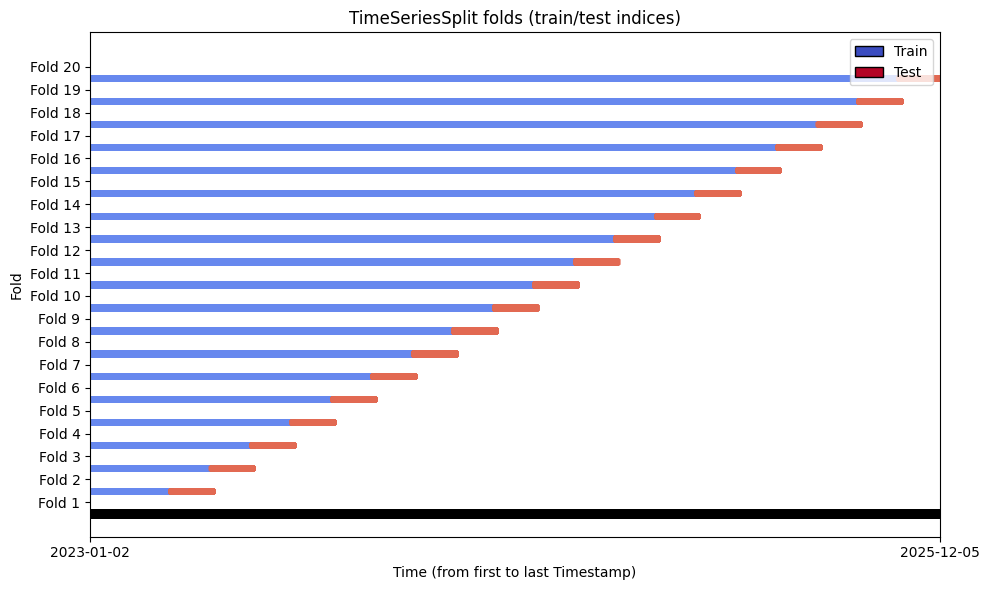

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit

# -------------------------------------------------------------
# TimeSeriesSplit visualization (time range on x-axis)
# -------------------------------------------------------------

n_splits = 20                     # same as in your training
tscv = TimeSeriesSplit(n_splits=n_splits)
splits = list(tscv.split(X, y))   # use same logic as for training

n_samples = len(X)
indices = np.arange(n_samples)
cmap_cv = plt.cm.coolwarm

fig, ax = plt.subplots(figsize=(10, 6))

# Plot train / test indices per fold
for idx, (train_idx, test_idx) in enumerate(splits):
    # initialize all as NaN (not drawn)
    fold_colors = np.full(n_samples, np.nan)
    fold_colors[train_idx] = 0   # train
    fold_colors[test_idx] = 1    # test

    ax.scatter(
        indices,
        np.full_like(indices, idx + 0.5),  # vertical position for this fold
        c=fold_colors,
        marker="s",
        s=10,
        cmap=cmap_cv,
        vmin=-0.2,
        vmax=1.2,
    )

# Optional: line of all samples at bottom
ax.scatter(
    indices,
    np.full_like(indices, -0.5),
    c="k",
    marker="|",
    s=50,
    label="Samples",
)

# Use first & last timestamps as x-axis labels
start_time = df_encoded["Timestamp"].iloc[0]
end_time   = df_encoded["Timestamp"].iloc[-1]

ax.set_ylabel("Fold")
ax.set_yticks(np.arange(n_splits) + 0.5)
ax.set_yticklabels([f"Fold {i+1}" for i in range(n_splits)])
ax.set_ylim(-1, n_splits + 1)
ax.set_xlim(0, n_samples)

ax.set_xlabel("Time (from first to last Timestamp)")
ax.set_xticks([0, n_samples - 1])
ax.set_xticklabels([
    start_time.strftime("%Y-%m-%d"),
    end_time.strftime("%Y-%m-%d"),
])

ax.set_title("TimeSeriesSplit folds (train/test indices)")

# Legend
legend_elements = [
    Patch(facecolor=cmap_cv(0.0), edgecolor="k", label="Train"),
    Patch(facecolor=cmap_cv(1.0), edgecolor="k", label="Test"),
]
ax.legend(handles=legend_elements, loc="upper right")
fig.tight_layout()
fig.savefig("timeseries_folds2.jpg", format="jpg", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()